In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv


In [2]:
lattice = lt.Lattice(lt.D3Q19, device = "cpu", dtype=torch.float64)
flow = lt.SuperReducedTaylorGreenVortex3D(resolution=64, reynolds_number=3000, mach_number=0.05, lattice=lattice)
print(flow.units.convert_time_to_lu(20))
collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
print(flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.SimulationReducedTGV(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

28228.03944559575
0.5011761683102331


In [3]:
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation_TGV=lt.Dissipation_TGV(lattice, flow)
reporter = lt.ObservableReporter(Energy, interval=10, out=None)
#Enstrophy=lt.Enstrophy(lattice,flow)
reporter2= lt.ObservableReporter(Dissipation_TGV, interval=10, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=10, filename_base="./output/out"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_TGV


In [4]:
simulation.initialize_f_neq()
mlups = simulation.step(num_steps=14000)
print("Performance in MLUPS:", mlups)
rho_start,u_start,f_start=simulation.startwerte()
print("rho_start")
print(rho_start)
print("u_start")
print(u_start)
print("f_start")
print(f_start)

Performance in MLUPS: 1.8517554883730496
rho_start
tensor([[[[1.0003, 1.0003, 1.0003,  ..., 1.0009, 1.0009, 1.0009],
          [1.0003, 1.0003, 1.0003,  ..., 1.0009, 1.0009, 1.0009],
          [1.0003, 1.0003, 1.0003,  ..., 1.0009, 1.0009, 1.0009],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0003, 1.0003, 1.0003,  ..., 1.0009, 1.0009, 1.0009],
          [1.0003, 1.0003, 1.0003,  ..., 1.0009, 1.0009, 1.0009],
          [1.0003, 1.0003, 1.0003,  ..., 1.0009, 1.0009, 1.0009],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0003, 1.0003, 1.0003,  ..., 1.0009, 1.0009, 1.0009],
          [1.0003, 1.0003, 1.0003,  ..., 1.0009, 1.0009, 

(1401, 3)


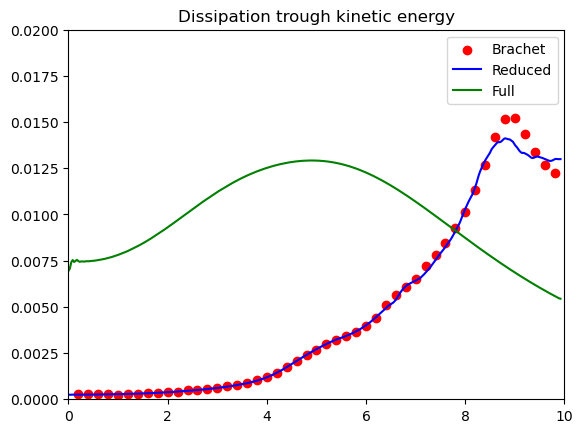

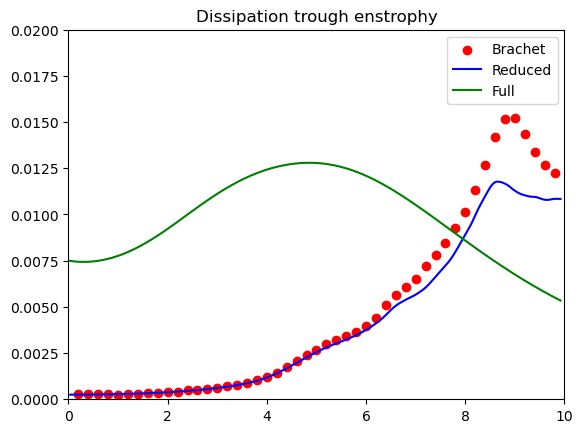

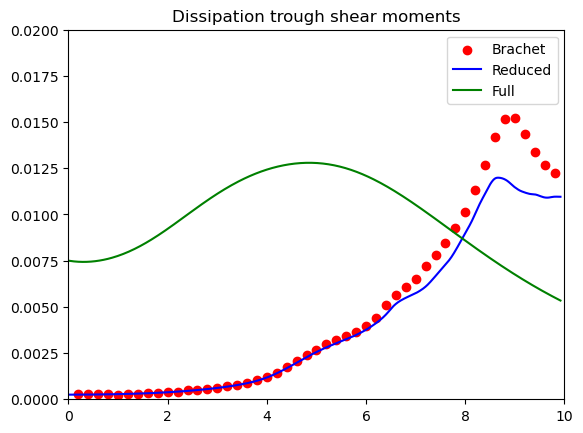

In [5]:
energy = np.array(simulation.reporters[0].out)
print(energy.shape)

#save_directory = outputdir
#file_name = "FullTGV.pkl"
#file_path = os.path.join(save_directory, file_name)
#simulation.save_checkpoint(file_path)

csv_file_path = '/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re3000.csv'

# Daten aus der CSV-Datei lesen
csv_data = []
FullTGV_DisEns=[]
FullTGV_DisEkin=[]
FullTGV_DisSij=[]
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        csv_data.append(row)

with open('/home/ben/Schreibtisch/ErgebnisseMP1/FullTGV/DisEns-Rey100-Res64-BGK.csv', 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        FullTGV_DisEns.append(row)

with open('/home/ben/Schreibtisch/ErgebnisseMP1/FullTGV/DisEkin-Rey100-Res64-BGK.csv', 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        FullTGV_DisEkin.append(row)

with open('/home/ben/Schreibtisch/ErgebnisseMP1/FullTGV/DisSij-Rey100-Res64-BGK.csv', 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        FullTGV_DisSij.append(row)

csv_data = np.array(csv_data, dtype=float)
FullTGV_DisEns= np.array(FullTGV_DisEns, dtype=float)
FullTGV_DisEkin= np.array(FullTGV_DisEkin, dtype=float)
FullTGV_DisSij= np.array(FullTGV_DisSij, dtype=float)



dissipation = np.array(simulation.reporters[1].out)

#print(energy.shape)
#plt.plot(energy[:,1],energy[:,2])
#plt.plot(energy[5:-1,1],-1/((np.pi*2)**3)*np.diff(energy[5:,2])/np.diff(energy[5:,1]))
#plt.plot(energy[3:,1],-1/(np.pi*2)**3*np.gradient(64*energy[3:,2],energy[3:,1]),color = 'blue')
#plt.plot(dissipation[3:,1],dissipation[3:,2], color = 'green')
#plt.plot(dissipation[5:,1],1/(0.5*np.pi)**3*dissipation[5:,3], color = 'yellow')
#plt.plot(enstrophy[:,1],1/(np.pi*2)**3*1/100*enstrophy[:,2])
#plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='CSV Data')
#plt.title('Energy Dissipation')
#plt.xlabel('Time')
#plt.ylabel('Energy Dissipation in physical units')
#plt.ylim(0,0.03)
#plt.show()

plt.figure(1)
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='Brachet')
plt.plot(energy[:,1],-1/(np.pi*2)**3*np.gradient(64*energy[:,2],energy[:,1]),color = 'blue', label='Reduced')
plt.plot(FullTGV_DisEkin[:,0],FullTGV_DisEkin[:,1],color='green', label='Full')
plt.xlim(0,10)
plt.ylim(0,0.02)
plt.legend()
title = 'Dissipation trough kinetic energy'
plt.title(title)
plt.savefig(title)

plt.figure(2)
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='Brachet')
plt.plot(dissipation[5:,1],1/(0.5*np.pi)**3*dissipation[5:,3], color = 'blue', label='Reduced')
plt.plot(FullTGV_DisEns[:,0],FullTGV_DisEns[:,1],color='green', label= 'Full')
plt.xlim(0,10)
plt.ylim(0,0.02)
plt.legend()
plt.title('Dissipation trough enstrophy')

plt.figure(3)
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='Brachet')
plt.plot(dissipation[3:,1],dissipation[3:,2], color = 'blue',label='Reduced')
plt.plot(FullTGV_DisSij[:,0],FullTGV_DisSij[:,1],color = 'green',label='Full')
plt.legend()
plt.xlim(0,10)
plt.ylim(0,0.02)
plt.title('Dissipation trough shear moments')

plt.show()

TypeError: Invalid shape (64, 64, 64) for image data

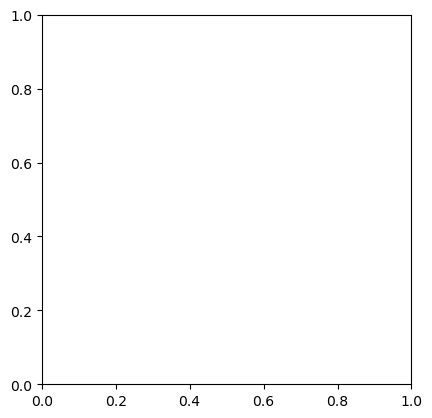

In [6]:
u = flow.units.convert_velocity_to_pu(lattice.u(simulation.f)).numpy()
u_norm = np.linalg.norm(u,axis=0)
plt.imshow(u_norm)
plt.show()